In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import argparse
import copy
import datetime

import ddd
import matplotlib.pyplot as plt
import torch
import utils
import utils_text
from diffusers import AutoencoderKL
from diffusers import BitsAndBytesConfig
from diffusers import StableDiffusionInpaintPipeline
from diffusers import UNet2DConditionModel
from PIL import Image
from PIL import ImageOps
from torchvision import transforms

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()
torch.backends.cuda.matmul.allow_tf32 = True

In [11]:
args_dict = {
    "prompt_len": 16,
    "iter": 3000,
    "lr": 0.1,
    "weight_decay": 0.1,
    "prompt_bs": 1,
    "loss_weight": 1.0,
    "print_step": 100,
    "batch_size": 1,
    "clip_model": "ViT-H-14",
    "clip_pretrain": "laion2b_s32b_b79k"
}


def dict_to_args_parser(input_dict):
  parser = argparse.ArgumentParser()
  for key, value in input_dict.items():
    parser.add_argument(f'--{key}', default=value, type=type(value))
  return parser.parse_args([])


args = dict_to_args_parser(args_dict)

In [12]:
# load img from img/{testimg_filename}.png, masked img is also required img/{testimg_filename}_masked.png
testimg_filename = "005"
device = "cuda"
dtype = torch.float16

model_version = "stabilityai/stable-diffusion-2-inpainting"

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)
unet_nf4 = UNet2DConditionModel.from_pretrained(
    model_version,
    subfolder="unet",
    quantization_config=nf4_config,
    torch_dtype=dtype,
    use_safetensors=True,
)

vae_nf4 = AutoencoderKL.from_pretrained(
    model_version,
    subfolder="vae",
    quantization_config=nf4_config,
    torch_dtype=dtype,
    use_safetensors=True,
)

pipe_inpaint: StableDiffusionInpaintPipeline = StableDiffusionInpaintPipeline.from_pretrained(
    model_version,
    variant="fp16",
    unet=unet_nf4,
    vae=vae_nf4,
    torch_dtype=dtype,
    use_safetensors=True,
)

# pipe_inpaint.vae = pipe_inpaint.vae.to(device, dtype)
pipe_inpaint.text_encoder = pipe_inpaint.text_encoder.to(device, dtype)
pipe_inpaint.unet.to(memory_format=torch.channels_last)
pipe_inpaint = pipe_inpaint.to(device=device, memory_format=torch.channels_last)
pipe_inpaint.safety_checker = None
pipe_inpaint.vae.requires_grad_(False)
pipe_inpaint.unet.requires_grad_(False)

size = 512
size_2d = (size, size)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
tokenizer = pipe_inpaint.tokenizer
token_embedding = pipe_inpaint.text_encoder.text_model.embeddings.token_embedding

preprocess = transforms.Compose(
    [
        transforms.Resize(
            size,
            interpolation=transforms.InterpolationMode.BILINEAR,
        ),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
    ]
)

In [14]:
# pipe_inpaint.to(torch_dtype=torch.float32)

orig_images = Image.open(f'./images/{testimg_filename}.png'
                        ).convert('RGB').resize(size_2d)
mask_image_orig = Image.open(f'./images/{testimg_filename}_masked.png'
                            ).convert('RGB').resize(size_2d)
mask_image = ImageOps.invert(mask_image_orig).resize(size_2d)

cur_mask, cur_masked_image, init_image = utils.prepare_mask_and_masked2(
    orig_images, mask_image, no_mask=False, inverted=True
)
inv_cur_mask, _, _ = utils.prepare_mask_and_masked2(
    orig_images, mask_image, no_mask=False, inverted=False
)

cur_mask = cur_mask.to(device, dtype)
cur_masked_image = cur_masked_image.to(device, dtype)

with torch.no_grad():
  curr_images = preprocess(orig_images).to(device)
  mask = torch.nn.functional.interpolate(cur_mask, size=(size // 8, size // 8))
  if len(curr_images.shape) == 3:
    curr_images = curr_images.unsqueeze(0)
  elif len(curr_images.shape) == 5:
    curr_images = curr_images.squeeze(0)
  all_latents = pipe_inpaint.vae.encode(curr_images.to(dtype)
                                       ).latent_dist.sample()
  all_latents = all_latents * 0.18215
  masked_image_latents = pipe_inpaint.vae.encode(cur_masked_image
                                                ).latent_dist.sample() * 0.18215
  gt_embeddings = utils.get_text_embedding(pipe_inpaint, testimg_filename)
  uncond_embeddings = utils.get_text_embedding(pipe_inpaint, "")


# Token Projective Embedding Optimization

In [15]:
args.prompt_len = 8
args.opt_iters = 350
args.eval_step = 50
# discrete = True
args.lr = 0.0001

In [16]:
args.lr = 0.001
prompt_embeds, dummy_embeds, dummy_ids = utils_text.initialize_prompt(
    tokenizer, token_embedding, args, device
)
input_optimizer = torch.optim.AdamW(
    [prompt_embeds],
    lr=args.lr,
    weight_decay=args.weight_decay,
)
input_optim_scheduler = None
best_loss = -999
eval_loss = -99999
best_text = ""
best_embeds = None
for step in range(args.opt_iters):
  if step > args.opt_iters - 10:  # Finalize with full continuous update
    args.lr = 0.0001
    projected_embeds, nn_indices = utils_text.nn_project(
        prompt_embeds, token_embedding
    )
    tmp_embeds = copy.deepcopy(prompt_embeds)
    tmp_embeds.data = projected_embeds.data
    tmp_embeds.requires_grad = True
  else:
    tmp_embeds = copy.deepcopy(prompt_embeds)
    tmp_embeds.data = prompt_embeds.data
    tmp_embeds.requires_grad = True

  padded_embeds = copy.deepcopy(dummy_embeds)
  padded_embeds[:, 1:args.prompt_len + 1] = tmp_embeds
  padded_embeds = padded_embeds.repeat(args.batch_size, 1, 1)
  padded_dummy_ids = dummy_ids.repeat(args.batch_size, 1)

  if args.batch_size is None:
    latents = all_latents
  else:
    perm = torch.randperm(len(all_latents))
    idx = perm[:args.batch_size]
    latents = all_latents[idx]

  noise = torch.randn_like(latents)
  bsz = latents.shape[0]
  timesteps = torch.randint(0, 1000, (bsz,), device=latents.device)
  timesteps = timesteps.long()

  noisy_latents = pipe_inpaint.scheduler.add_noise(latents, noise, timesteps)

  if pipe_inpaint.scheduler.config.prediction_type == "epsilon":
    target = noise
  elif pipe_inpaint.scheduler.config.prediction_type == "v_prediction":
    target = pipe_inpaint.scheduler.get_velocity(latents, noise, timesteps)
  else:
    raise ValueError(
        f"Unknown prediction type {pipe_inpaint.scheduler.config.prediction_type}"
    )

  text_embeddings = utils_text.get_text_embedding_with_embeddings(
      pipe_inpaint, padded_dummy_ids, padded_embeds
  )

  input_latent = torch.cat([noisy_latents, mask, masked_image_latents], dim=1)
  model_pred = pipe_inpaint.unet.forward(
      input_latent,
      timesteps,
      encoder_hidden_states=text_embeddings,
      return_dict=False
  )[0]
  inverted_mask = mask

  target = target * inverted_mask
  model_pred = model_pred * inverted_mask
  loss = torch.nn.functional.mse_loss(
      model_pred.float(), target.float(), reduction="mean"
  )
  prompt_embeds.grad, = torch.autograd.grad(loss, [tmp_embeds])
  input_optimizer.step()
  input_optimizer.zero_grad()

  curr_lr = input_optimizer.param_groups[0]["lr"]

KeyboardInterrupt: 

In [ ]:
input_text_embedding = text_embeddings.detach()
input_text_embeddings = torch.cat([input_text_embedding] * 2)

In [ ]:
# pipe_inpaint.to(torch_dtype=torch.float16)

# for testimg_filename in test_file_list:
prefix_filename = "./images/" + testimg_filename
init_image = Image.open(f"{prefix_filename}.png").convert("RGB").resize(size_2d)
mask_image = Image.open(f"{prefix_filename}_masked.png").convert("RGB")
mask_image = ImageOps.invert(mask_image).resize(size_2d)

target_prompt = ""

prompt = ""
SEED = 786349
torch.manual_seed(SEED)

cur_mask, cur_masked_image = utils.prepare_mask_and_masked(
    init_image, mask_image
)

cur_mask = cur_mask.to(dtype=dtype, device=device)
cur_masked_image = cur_masked_image.to(dtype=dtype, device=device)

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 4

text_embeddings = utils.text_embedding(pipe_inpaint, target_prompt)

latents_shape = (
    1, pipe_inpaint.vae.config.latent_channels, size // 8, size // 8
)
noise = torch.randn(latents_shape, device=device, dtype=text_embeddings.dtype)

image_latent = utils.pil_to_latent(pipe_inpaint, init_image)


# Monte Carlo sampling (Semantic Centroid Construction)

In [ ]:
prompt = ""
SEED = 786349

t_schedule = [720]
t_schedule_bound = 10
n_samples = 50
loss_depth = [256, 64]

torch.manual_seed(SEED)

cur_mask, cur_masked_image = utils.prepare_mask_and_masked(
    init_image, mask_image
)

cur_mask = cur_mask.to(device=device, dtype=dtype)
cur_masked_image = cur_masked_image.to(device=device, dtype=dtype)

val_loss_criteria = "MSE"
attn_controller = ddd.AttnController(
    post=False,
    mask=cur_mask,
    criteria=val_loss_criteria,
    target_depth=loss_depth
)

module_count = 0
modes = ['', 'up', 'down']
mode = 0
# to collect only up or down attns, please deactivate the annotation of 'if' statement below
for n, m in pipe_inpaint.unet.named_modules():
  # if (n.endswith('attn2') and (modes[mode] in n)) or (n.endswith('attn1') and (modes[mode] in n)): #and "down" in n:
  if (n.endswith('attn1') and (modes[mode] in n)):  #and "down" in n:
    attn_processor = ddd.MyCrossAttnProcessor(attn_controller, n)
    attn_processor.__call__ = torch.compile(
        attn_processor.__call__,
        backend="cudagraphs",
        fullgraph=True,
    )

    m.set_processor(attn_processor)
    module_count += 1

sp_prompt = None

for_mean = []
for j in range(n_samples):
  with torch.no_grad():
    mask = cur_mask
    masked_image = cur_masked_image
    random_t = ddd.get_random_t(t_schedule, t_schedule_bound)
    uncond_emb = input_text_embeddings
    num_channels_latents = pipe_inpaint.vae.config.latent_channels
    latents_shape = (1, num_channels_latents, size // 8, size // 8)
    latents = torch.randn(latents_shape, device=device, dtype=uncond_emb.dtype)

    mask = torch.nn.functional.interpolate(mask, size=(size // 8, size // 8))
    mask = torch.cat([mask] * 2)
    masked_image_latents = pipe_inpaint.vae.encode(masked_image
                                                  ).latent_dist.sample()
    masked_image_latents = 0.18215 * masked_image_latents
    masked_image_latents = torch.cat([masked_image_latents] * 2)

    pipe_inpaint.scheduler.set_timesteps(num_inference_steps)
    timesteps_tensor = pipe_inpaint.scheduler.timesteps.to(device)
    timesteps_tensor = random_t

    for i, t in enumerate(timesteps_tensor):

      latent_model_input = torch.cat([latents] * 2)
      latent_model_input = torch.cat(
          [latent_model_input, mask, masked_image_latents], dim=1
      )
      pipe_inpaint.unet.forward(
          sample=latent_model_input,
          timestep=t,
          encoder_hidden_states=uncond_emb,
          return_dict=False,
      )
      # _ = pipe_inpaint.unet(
      #     latent_model_input, t, encoder_hidden_states=uncond_emb
      # ).sample
    for_mean.append(attn_controller.targets)
    attn_controller.zero_attn_probs()
meaned = []
for feature in range(len(for_mean[0])):
  temp = 0
  for idx in range(n_samples):
    temp += for_mean[idx][feature]
  temp /= n_samples
  meaned.append(temp)

attn_controller.target_hidden = meaned
del for_mean, meaned
text_embeddings = [uncond_emb]

# Semantic Digression

In [ ]:
now = datetime.datetime.now()
now = str(now)[:19].replace(" ", "_")
nickname = f"run"
directory = f"{nickname}_{now}"
path = f"figures/{directory}"
img_path = path + "/img"
adv_path = path + "/adv"
os.makedirs(path)
os.makedirs(img_path)
os.makedirs(adv_path)

infer_dict = dict()
infer_dict["prompt"] = utils.load_prompt(f"prompts/{testimg_filename}.txt")[0]
infer_dict["num_inference_steps"] = 20
infer_dict["guidance_scale"] = 7.5
infer_dict["strength"] = 0.8
infer_dict["init_image"] = init_image
infer_dict["mask"] = mask_image
infer_dict["prefix"] = 'inter'
infer_dict["path"] = img_path
infer_dict["inter_print"] = []

# iters = 100
iters = 250
grad_reps = 7
loss_mask = True
eps = 12
step_size = 3
pixel_loss = 0
# val_loss_criteria = "MSE"

pipe_inpaint.text_encoder = pipe_inpaint.text_encoder.to(device="cpu")
pipe_inpaint.vae.decoder = pipe_inpaint.vae.decoder.to(device="cpu")
pipe_inpaint.vae.post_quant_conv = pipe_inpaint.vae.post_quant_conv.to(
    device="cpu"
)

result, total_losses = ddd.disrupt(
    cur_mask,
    cur_masked_image,
    text_embeddings=text_embeddings,
    eps=eps,
    step_size=step_size,
    iters=iters,
    clamp_min=-1,
    clamp_max=1,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    grad_reps=grad_reps,
    attn_controller=attn_controller,
    pipe=pipe_inpaint,
    loss_depth=loss_depth,
    loss_mask=loss_mask,
    pixel_loss=pixel_loss,
    t_schedule=t_schedule,
    t_schedule_bound=t_schedule_bound,
    infer_dict=infer_dict,
    infer_unet=pipe_inpaint.unet,
    inter_print=infer_dict["inter_print"],
)
torch.save(result, f'{adv_path}/adv.pt')

Loss: -4.65495: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


[
-0.2454833984375,
-0.23368326822916666,
-0.2986653645833333,
-0.340576171875,
-0.4095052083333333,
-0.4816080729166667,
-0.64794921875,
-0.701171875,
-0.8331705729166666,
-0.95947265625,
-1.2037760416666667,
-1.4482421875,
-1.4798177083333333,
-1.5276692708333333,
-1.8587239583333333,
-2.0345052083333335,
-2.1321614583333335,
-2.384765625,
-2.3678385416666665,
-2.517578125,
-2.6640625,
-2.775390625,
-2.8333333333333335,
-2.8151041666666665,
-2.888671875,
-2.951171875,
-3.1256510416666665,
-3.1236979166666665,
-3.1979166666666665,
-3.2434895833333335,
-3.1770833333333335,
-3.38671875,
-3.3125,
-3.5358072916666665,
-3.5423177083333335,
-3.5240885416666665,
-3.3092447916666665,
-3.546875,
-3.619140625,
-3.6764322916666665,
-3.5455729166666665,
-3.7200520833333335,
-3.689453125,
-3.7552083333333335,
-3.7200520833333335,
-3.7005208333333335,
-3.6907552083333335,
-3.7760416666666665,
-3.84765625,
-3.962890625,
-4.0703125,
-4.123697916666667,
-3.857421875,
-4.106770833333333,
-4.04296875,
-

[]

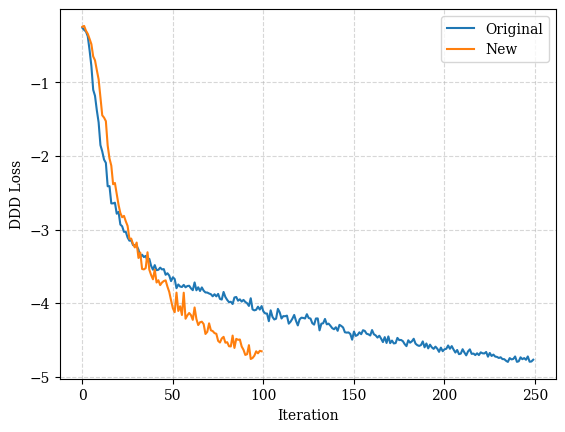

In [ ]:
# Plot the total lossese
import seaborn as sns
import numpy as np

# old = total_losses
# print(xs)
xs = [
    -0.25895051445279804, -0.2871526224272592, -0.30943128892353605,
    -0.3739359165940966, -0.5622538200446537, -0.7789701904569354,
    -1.1014966113226754, -1.1832793951034546, -1.3790552956717355,
    -1.5440011365073067, -1.852931124823434, -1.9388800859451294,
    -2.0503952503204346, -2.0945151703698293, -2.41251083782741,
    -2.4103075095585416, -2.645394836153303, -2.6447297164372037,
    -2.6356772014072964, -2.785411528178624, -2.760767732347761,
    -2.9322990008762906, -2.956448725291661, -3.031250102179391,
    -3.032038143702916, -3.1083658763340543, -3.151808398110526,
    -3.1477530002593994, -3.211890322821481, -3.209975378853934,
    -3.2204392978123257, -3.273127453667777, -3.380068404333932,
    -3.3421768801552907, -3.3746556554521834, -3.3580390385219028,
    -3.426422323499407, -3.3986824921199252, -3.494025775364467,
    -3.5463028294699535, -3.483870370047433, -3.552634068897792,
    -3.5474012919834683, -3.5179507732391357, -3.5422700132642473,
    -3.5378527300698415, -3.6149160180773054, -3.594184841428484,
    -3.6255787440708707, -3.7011802537100658, -3.649008580616542,
    -3.6726017338888988, -3.797564915248326, -3.7469630241394043,
    -3.7748281955718994, -3.780999251774379, -3.752155303955078,
    -3.7852074759347096, -3.7680020332336426, -3.7642684323447093,
    -3.799792834690639, -3.824455874306815, -3.719146830695016,
    -3.825737374169486, -3.785043375832694, -3.8352475506918773,
    -3.7870259625571117, -3.8308372838156566, -3.855483191353934,
    -3.8564262049538747, -3.869621923991612, -3.8792765140533447,
    -3.9075658661978587, -3.8794166019984653, -3.908699103764125,
    -3.8751015663146973, -3.942824499947684, -3.9520117895943776,
    -3.848691667829241, -3.917041369846889, -3.956806489399501,
    -3.986866065434047, -3.9820143835885182, -4.012018169675555,
    -3.923675605228969, -3.9168049607958113, -3.9675253118787492,
    -3.948641334261213, -3.979196752820696, -3.956390312739781,
    -3.984365701675415, -4.001713139670236, -4.038400615964617,
    -3.9338132994515553, -4.085871492113386, -4.098568167005267,
    -4.090785537447248, -4.048543998173305, -4.087616750172207,
    -4.040594169071743, -4.113360336848667, -4.139982836587088,
    -4.142045668193272, -4.24583421434675, -4.097948755536761,
    -4.186783109392438, -4.222413335527692, -4.211480958121164,
    -4.0783820152282715, -4.125299249376569, -4.208914007459368,
    -4.176817689623151, -4.178276198250907, -4.170234543936593,
    -4.279388904571533, -4.252256461552212, -4.211903844560895,
    -4.160982097898211, -4.240941933223179, -4.303183555603027,
    -4.220615318843296, -4.197685241699219, -4.201778275626046,
    -4.208938462393625, -4.1507750919887, -4.202846799577985,
    -4.209532567432949, -4.27336665562221, -4.292234148297991,
    -4.20919452394758, -4.20814847946167, -4.370381082807269,
    -4.2797048432486395, -4.27382264818464, -4.215234211512974,
    -4.288348811013358, -4.278899737766811, -4.307537351335798,
    -4.340213366917202, -4.355097157614572, -4.328309263501849,
    -4.376380171094622, -4.295324121202741, -4.310568945748465,
    -4.3311518260410855, -4.3963398933410645, -4.401116507393973,
    -4.398109231676374, -4.419940062931606, -4.497102669307163,
    -4.386872972760882, -4.445404665810721, -4.432929175240653,
    -4.396689346858433, -4.42210899080549, -4.368221419198172,
    -4.378213405609131, -4.416540350232806, -4.424036094120571,
    -4.440341404506138, -4.366152354649135, -4.423092092786517,
    -4.438840525490897, -4.468578951699393, -4.442953245980399,
    -4.482965196881976, -4.529453618185861, -4.4621773447309225,
    -4.541603020259312, -4.45260763168335, -4.544095993041992,
    -4.509138924734933, -4.548019886016846, -4.543276105608259,
    -4.472849300929478, -4.502554416656494, -4.500528199332101,
    -4.516921656472342, -4.556815079280308, -4.584707464490618,
    -4.505070958818708, -4.537848336356027, -4.518459115709577,
    -4.484412942613874, -4.55073424748012, -4.571447849273682,
    -4.581712109701974, -4.570349829537528, -4.5203704833984375,
    -4.600469997950962, -4.548523494175503, -4.61500528880528,
    -4.564542021070208, -4.601077352251325, -4.621880871909005,
    -4.5913823672703336, -4.618913105555943, -4.662309510367257,
    -4.604953016553607, -4.653347560337612, -4.627956458500454,
    -4.620264121464321, -4.575964178357806, -4.620394706726074,
    -4.584318774087088, -4.630825587681362, -4.6715231622968405,
    -4.637314864567348, -4.693474633353097, -4.6865337916782925,
    -4.626625674111502, -4.671591281890869, -4.709819044385638,
    -4.656140191214425, -4.628488540649414, -4.68979161126273,
    -4.68526029586792, -4.705962385450091, -4.681829452514648,
    -4.706166335514614, -4.668993404933384, -4.681757858821324,
    -4.684283256530762, -4.664075442722866, -4.727869987487793,
    -4.677402905055454, -4.718313489641462, -4.699434007917132,
    -4.726446424211774, -4.730991772242954, -4.745829105377197,
    -4.735935143062046, -4.760604926518032, -4.76200566973005,
    -4.7839901106698175, -4.799150739397321, -4.747198377336774,
    -4.765226909092495, -4.758673531668527, -4.725130149296352,
    -4.7979873929704935, -4.790339401790074, -4.73673643384661,
    -4.761966296604702, -4.747232232775007, -4.770268304007394,
    -4.724764278956822, -4.7963730267116, -4.793282304491315,
    -4.7691843169076105
]
new = np.array(total_losses)[:, 0]

# Print new as a comma separated list
print("[")
print(",\n".join([str(x) for x in new]))
print("]")

# xs = np.array(old)[:,0]

sns.lineplot(x=range(len(xs)), y=xs, label="Original")
sns.lineplot(x=range(len(new)), y=new, label="New")
# sns.lineplot(x=range(len(new)), y=new)
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.xlabel("Iteration")
plt.ylabel("DDD Loss")
plt.plot()

# Inference

In [ ]:
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    model_version,
    variant="fp16",
    torch_dtype=torch.float32,
    use_safetensors=True,
)
pipe_inpaint = pipe_inpaint.to("cuda")
pipe_inpaint.safety_checker = None

for name, param in pipe_inpaint.unet.named_parameters():
  param.requires_grad = False

directory = f"{nickname}_{now}"
path = f"figures/{directory}"
img_path = path + "/img"
adv_path = path + "/adv"
result = torch.load(f'{adv_path}/adv.pt')[0]
adv_X = (result / 2 + 0.5).clamp(0, 1)
adv_image = to_pil(adv_X.to(torch.float32)).convert("RGB")
adv_image = utils.recover_image(
    adv_image, init_image, mask_image, background=True
)
adv_image.show()

# Show the difference between the original image and the adversarial image
diff = to_tensor(adv_image) - to_tensor(init_image)
diff = to_pil(diff)
diff.show()

os.makedirs("./adversarial", exist_ok=True)

adv_image.save(f'./adversarial/{testimg_filename}_adv.png')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_170255/3451627980.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  result = torch.load(f'{adv_path}/adv.pt')[0]


['A man in a restaurant']
1007


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

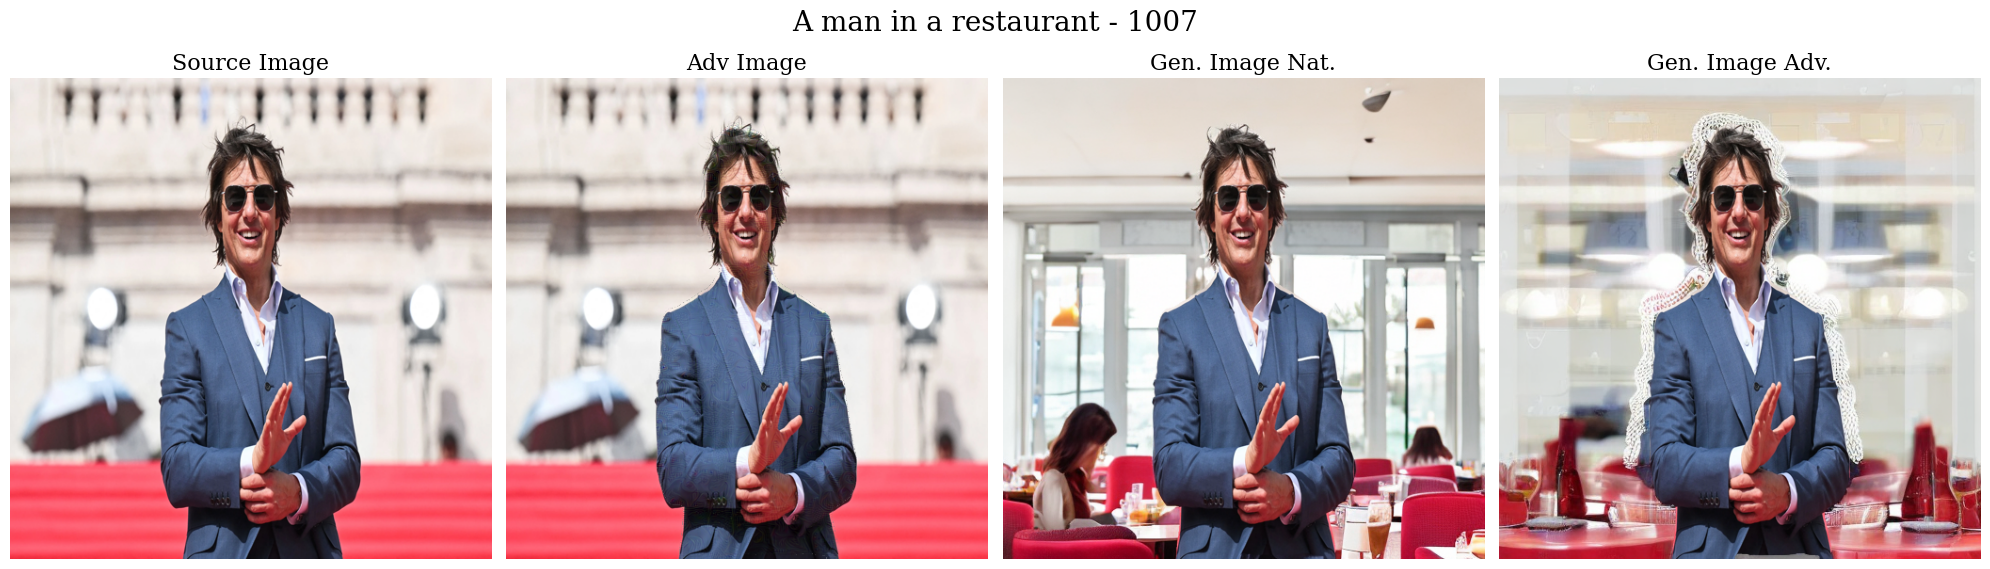

<Figure size 640x480 with 0 Axes>

In [ ]:
prompts = utils.load_prompt(f"prompts/{testimg_filename}.txt")
print(prompts)

# prompts = ["a woman with a hat on a beach in black and white"]

SEED = 1007

with torch.no_grad():
  for prompt in prompts:

    print(SEED)

    torch.manual_seed(SEED)
    strength = 0.8
    guidance_scale = 7.5

    num_inference_steps = 50

    image_nat = pipe_inpaint(
        prompt=prompt,
        image=init_image,
        mask_image=mask_image,
        eta=1,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        strength=strength
    ).images[0]
    image_nat = utils.recover_image(image_nat, init_image, mask_image)

    torch.manual_seed(SEED)
    image_adv = pipe_inpaint(
        prompt=prompt,
        image=adv_image,
        mask_image=mask_image,
        eta=1,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        strength=strength
    ).images[0]

    image_adv = utils.recover_image(image_adv, init_image, mask_image)

    image_adv.save(f'{img_path}/{prompt[:40]}_adv.png')
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

    ax[0].imshow(init_image)
    ax[1].imshow(adv_image)
    ax[2].imshow(image_nat)
    ax[3].imshow(image_adv)

    ax[0].set_title('Source Image', fontsize=16)
    ax[1].set_title('Adv Image', fontsize=16)
    ax[2].set_title('Gen. Image Nat.', fontsize=16)
    ax[3].set_title('Gen. Image Adv.', fontsize=16)

    for i in range(4):
      ax[i].grid(False)
      ax[i].axis('off')

    fig.suptitle(f"{prompt} - {SEED}", fontsize=20)
    fig.tight_layout()
    plt.savefig(f'{img_path}/{prompt}.png')
    plt.show()

    plt.clf()